In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
!cp "/content/drive/My Drive/4995/ProjectMM/Crop_Data.zip" "/content"
!unzip '/content/Crop_Data.zip'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Crop_Data/level6/valid/mask/01751.jpg  
  inflating: Crop_Data/level6/valid/mask/01752.jpg  
  inflating: Crop_Data/level6/valid/mask/01753.jpg  
  inflating: Crop_Data/level6/valid/mask/01754.jpg  
  inflating: Crop_Data/level6/valid/mask/01755.jpg  
  inflating: Crop_Data/level6/valid/mask/01756.jpg  
  inflating: Crop_Data/level6/valid/mask/01757.jpg  
  inflating: Crop_Data/level6/valid/mask/01758.jpg  
  inflating: Crop_Data/level6/valid/mask/01759.jpg  
  inflating: Crop_Data/level6/valid/mask/01760.jpg  
  inflating: Crop_Data/level6/valid/mask/01761.jpg  
  inflating: Crop_Data/level6/valid/mask/01762.jpg  
  inflating: Crop_Data/level6/valid/mask/01763.jpg  
  inflating: Crop_Data/level6/valid/mask/01764.jpg  
  inflating: Crop_Data/level6/valid/mask/01765.jpg  
  inflating: Crop_Data/level6/valid/mask/01766.jpg  
  inflating: Crop_Data/level6/valid/mask/01767.jpg  
  inflating: Crop_Data/level6/valid/mask/01768.jpg  
  inflating: Crop_D

In [2]:
import os
import tensorflow as tf
import keras
from PIL import Image
from PIL import ImageEnhance
import random
import numpy as np
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import copy

In [3]:
level = 2
my_path = '/content'

In [14]:
train_image_path = my_path+'/Crop_Data/level'+str(level)+'/train/image/'
valid_image_path = my_path+'/Crop_Data/level'+str(level)+'/valid/image/'
test_image_path = my_path+'/Crop_Data/level'+str(level)+'/test/image/'
train_label_path = my_path+'/Crop_Data/level'+str(level)+'/train/mask/'
valid_label_path = my_path+'/Crop_Data/level'+str(level)+'/valid/mask/'
test_label_path = my_path+'/Crop_Data/level'+str(level)+'/test/mask/'

In [ ]:
print('Train data number: ', len(os.listdir(train_image_path)), 'Train mask number: ', len(os.listdir(train_label_path)))
print('Valid data number: ', len(os.listdir(valid_image_path)), 'Valid mask number: ', len(os.listdir(valid_label_path)))
print('Test data number: ', len(os.listdir(test_image_path)), 'Test mask number: ', len(os.listdir(test_label_path)))
assert len(os.listdir(train_image_path)) == len(os.listdir(train_label_path))
assert len(os.listdir(valid_image_path)) == len(os.listdir(valid_label_path))
assert len(os.listdir(test_image_path)) == len(os.listdir(test_label_path))

In [18]:
def My_DataGenerator(batch_size, level, category):

  image_path = my_path+'/Crop_Data/level'+str(level)+'/'+category+'/image/'
  label_path = my_path+'/Crop_Data/level'+str(level)+'/'+category+'/mask/'
  image_path_up2 = my_path+'/Crop_Data/level'+str(level+2)+'/'+category+'/image/'
  label_path_up2 = my_path+'/Crop_Data/level'+str(level+2)+'/'+category+'/mask/'
  image_path_up4 = my_path+'/Crop_Data/level'+str(level+4)+'/'+category+'/image/'
  label_path_up4 = my_path+'/Crop_Data/level'+str(level+4)+'/'+category+'/mask/'

  imageList = sorted(os.listdir(image_path))
  labelList = sorted(os.listdir(label_path))
  img = Image.open(image_path + imageList[0])
  img = np.array(img)
  imageList_up2 = sorted(os.listdir(image_path_up2))
  labelList_up2 = sorted(os.listdir(label_path_up2))
  img_up2 = Image.open(image_path_up2 + imageList_up2[0])
  img_up2 = np.array(img_up2)
  imageList_up4 = sorted(os.listdir(image_path_up4))
  labelList_up4 = sorted(os.listdir(label_path_up4))
  img_up4 = Image.open(image_path_up4 + imageList_up4[0])
  img_up4 = np.array(img_up4)
  while True:
    image_generator = np.zeros((batch_size, img.shape[0], img.shape[1], 3), np.float32)
    label_generator = np.zeros((batch_size, img.shape[0], img.shape[1], 1), np.uint8)
    image_generator_up2 = np.zeros((batch_size, img_up2.shape[0], img_up2.shape[1], 3), np.float32)
    label_generator_up2 = np.zeros((batch_size, img_up2.shape[0], img_up2.shape[1], 1), np.uint8)
    image_generator_up4 = np.zeros((batch_size, img_up4.shape[0], img_up4.shape[1], 3), np.float32)
    label_generator_up4 = np.zeros((batch_size, img_up4.shape[0], img_up4.shape[1], 1), np.uint8)

    for j in range(batch_size):
      rand = random.randint(0, len(imageList)-1)

      assert imageList[rand] == labelList[rand]
      assert imageList_up2[rand] == labelList_up2[rand]
      assert imageList_up4[rand] == labelList_up4[rand]

      image = Image.open(image_path + imageList[rand])
      label = Image.open(label_path + labelList[rand])
      image_up2 = Image.open(image_path_up2 + imageList_up2[rand])
      label_up2 = Image.open(label_path_up2 + labelList_up2[rand])
      image_up4 = Image.open(image_path_up4 + imageList_up4[rand])
      label_up4 = Image.open(label_path_up4 + labelList_up4[rand])

      # Data augmentation
      i = np.random.choice(range(4))
      if i == 1 or 3:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        label = label.transpose(Image.FLIP_LEFT_RIGHT)
        image_up2 = image_up2.transpose(Image.FLIP_LEFT_RIGHT)
        label_up2 = label_up2.transpose(Image.FLIP_LEFT_RIGHT)
        image_up4 = image_up4.transpose(Image.FLIP_LEFT_RIGHT)
        label_up4 = label_up4.transpose(Image.FLIP_LEFT_RIGHT)
      if i == 2 or 3:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
        label = label.transpose(Image.FLIP_TOP_BOTTOM)
        image_up2 = image_up2.transpose(Image.FLIP_TOP_BOTTOM)
        label_up2 = label_up2.transpose(Image.FLIP_TOP_BOTTOM)
        image_up4 = image_up4.transpose(Image.FLIP_TOP_BOTTOM)
        label_up4 = label_up4.transpose(Image.FLIP_TOP_BOTTOM)
      
      def enchance_image(image):
        u_bri = np.random.uniform(0.8,1.2)
        enh_bri = ImageEnhance.Brightness(image)
        image = enh_bri.enhance(factor=u_bri)
        u_col = np.random.uniform(0.8,1.2)
        enh_col = ImageEnhance.Color(image)
        image = enh_col.enhance(factor=u_col)
        u_con = np.random.uniform(0.8,1.2)
        enh_con = ImageEnhance.Contrast(image)
        image = enh_con.enhance(factor=u_con)
        return image

      u = np.random.uniform()
      if category == 'train' and u < 0.5:
        image = enchance_image(image)
        image_up2 = enchance_image(image_up2)
        image_up4 = enchance_image(image_up4)

      image_p = np.array(image)/255
      label_p = np.array(label)/255
      label_p[label_p<0.5] = 0
      label_p[label_p>=0.5] = 1
      label_p = label_p[:,:,np.newaxis]

      image_p_up2 = np.array(image_up2)/255
      label_p_up2 = np.array(label_up2)/255
      label_p_up2[label_p_up2<0.5] = 0
      label_p_up2[label_p_up2>=0.5] = 1
      label_p_up2 = label_p_up2[:,:,np.newaxis]

      image_p_up4 = np.array(image_up4)/255
      label_p_up4 = np.array(label_up4)/255
      label_p_up4[label_p_up4<0.5] = 0
      label_p_up4[label_p_up4>=0.5] = 1
      label_p_up4 = label_p_up4[:,:,np.newaxis]

      image_generator[j] = image_p
      label_generator[j] = label_p
      image_generator_up2[j] = image_p_up2
      label_generator_up2[j] = label_p_up2
      image_generator_up4[j] = image_p_up4
      label_generator_up4[j] = label_p_up4

    image_generator = tf.cast(image_generator, dtype=tf.float32)
    label_generator = tf.cast(label_generator, dtype=tf.int32)
    image_generator_up2 = tf.cast(image_generator_up2, dtype=tf.float32)
    label_generator_up2 = tf.cast(label_generator_up2, dtype=tf.int32)
    image_generator_up4 = tf.cast(image_generator_up4, dtype=tf.float32)
    label_generator_up4 = tf.cast(label_generator_up4, dtype=tf.int32)

    yield (image_generator,image_generator_up2,image_generator_up4), (label_generator,label_generator_up2,label_generator_up4)
    

In [ ]:
def my_unet(input_shape1=(256,256,3), input_shape2=(64,64,3), input_shape3=(16,16,3), n_filters=16, dropout=0.1, batchnorm=True, padding='same'):

  # 定义一个多次使用的卷积块
  def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
    # the first layer
    x = Conv2D(n_filters, kernel_size, padding=padding)(
        input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # the second layer
    x = Conv2D(n_filters, kernel_size, padding=padding)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    X = Activation('relu')(x)
    return X

  # 构建一个输入
  img1 = Input(shape=input_shape1)
  img2 = Input(shape=input_shape2)
  img3 = Input(shape=input_shape3)

  # contracting path
  c1 = conv2d_block(img1, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout * 0.5)(p1)

  c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  d1 = conv2d_block(img2, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
  q1 = MaxPooling2D((2, 2))(d1)
  q1 = Dropout(dropout * 0.5)(q1)

  c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  d2 = conv2d_block(q1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
  q2 = MaxPooling2D((2, 2))(d2)
  q2 = Dropout(dropout * 0.5)(q2)

  c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  e1 = conv2d_block(img3, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

  p4 = concatenate([p4,q2,e1])

  c5 = conv2d_block(p4, n_filters=n_filters * 22, kernel_size=3, batchnorm=batchnorm, padding=padding)

  output3 = Conv2D(1, (1, 1), activation='sigmoid')(c5)

  u6 = Conv2DTranspose(n_filters * 10, (3, 3), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters=n_filters * 10, kernel_size=3, batchnorm=batchnorm, padding=padding)

  o2 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c5)
  o2 = concatenate([o2, q1])
  o2 = Dropout(dropout)(o2)
  d3 = conv2d_block(o2, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)

  o3 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(d3)
  d4 = conv2d_block(o3, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
  output2 = Conv2D(1, (1, 1), activation='sigmoid')(d4)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

  output1 = Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[img1,img2,img3], outputs=[output1,output2,output3])
  #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  my_loss1 = focal_loss(2,0.93,1)
  my_loss2 = focal_loss(2,0.93,12)
  my_loss3 = focal_loss(2,0.93,144)
  model.compile(optimizer = Adam(lr = 1e-4), loss = [my_loss1, my_loss2, my_loss3], loss_weights = [1,1,1], metrics = ['accuracy'])

  return model

In [ ]:
def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
  # the first layer
  x = Conv2D(n_filters, kernel_size, padding=padding)(
      input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # the second layer
  x = Conv2D(n_filters, kernel_size, padding=padding)(x)
  if batchnorm:
      x = BatchNormalization()(x)
  X = Activation('relu')(x)
  return X
x1 = np.ones((2,256,256,3), dtype=np.float32)
x2 = np.ones((2,64,64,3), dtype=np.float32)
x3 = np.ones((2,16,16,3), dtype=np.float32)
n_filters = 16
batchnorm = False
padding = 'same'
dropout = 0.1

In [ ]:
c1 = conv2d_block(x1, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c1',c1.shape)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(dropout * 0.5)(p1)
print('p1',p1.shape)

c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c2',c2.shape)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(dropout)(p2)
print('p2',p2.shape)

d1 = conv2d_block(x2, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('d1',d1.shape)
q1 = MaxPooling2D((2, 2))(d1)
q1 = Dropout(dropout * 0.5)(q1)
print('q1',q1.shape)

c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c3',c3.shape)
p3 = MaxPooling2D((2, 2))(c3)
p3 = Dropout(dropout)(p3)
print('p3',p3.shape)

d2 = conv2d_block(q1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('d2',d2.shape)
q2 = MaxPooling2D((2, 2))(d2)
q2 = Dropout(dropout * 0.5)(q2)
print('q2',q2.shape)

c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c4',c4.shape)
p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(dropout)(p4)
print('p4',p4.shape)

e1 = conv2d_block(x3, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('e1',e1.shape)

p4 = concatenate([p4,q2,e1])
print('p4',p4.shape)

c5 = conv2d_block(p4, n_filters=n_filters * 22, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c5',c5.shape)

output3 = Conv2D(1, (1, 1), activation='sigmoid')(c5)
print('output3',output3.shape)

u6 = Conv2DTranspose(n_filters * 10, (3, 3), strides=(2, 2), padding='same')(c5)
print('u6',u6.shape)
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters * 10, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c6',c6.shape)

o2 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c5)
print('o2',o2.shape)
o2 = concatenate([o2, q1])
o2 = Dropout(dropout)(o2)
d3 = conv2d_block(o2, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('d3',d3.shape)

u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
print('u7',u7.shape)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c7',c7.shape)

o3 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(d3)
print('o3',o3.shape)
d4 = conv2d_block(o3, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('d4',d4.shape)
output2 = Conv2D(1, (1, 1), activation='sigmoid')(d4)
print('output2',output2.shape)

u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
print('u8',u8.shape)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c8',c8.shape)

u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
print('u9',u9.shape)
u9 = concatenate([u9, c1])
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
print('c9',c9.shape)

output1 = Conv2D(1, (1, 1), activation='sigmoid')(c9)
print('output1', output1.shape)

c1 (2, 256, 256, 16)
p1 (2, 128, 128, 16)
c2 (2, 128, 128, 32)
p2 (2, 64, 64, 32)
d1 (2, 64, 64, 16)
q1 (2, 32, 32, 16)
c3 (2, 64, 64, 64)
p3 (2, 32, 32, 64)
d2 (2, 32, 32, 32)
q2 (2, 16, 16, 32)
c4 (2, 32, 32, 128)
p4 (2, 16, 16, 128)
e1 (2, 16, 16, 16)
p4 (2, 16, 16, 176)
c5 (2, 16, 16, 352)
output3 (2, 16, 16, 1)
u6 (2, 32, 32, 160)
c6 (2, 32, 32, 160)
o2 (2, 32, 32, 32)
d3 (2, 32, 32, 32)
u7 (2, 64, 64, 64)
c7 (2, 64, 64, 64)
o3 (2, 64, 64, 16)
d4 (2, 64, 64, 16)
output2 (2, 64, 64, 1)
u8 (2, 128, 128, 32)
c8 (2, 128, 128, 32)
u9 (2, 256, 256, 16)
c9 (2, 256, 256, 16)
output1 (2, 256, 256, 1)


In [5]:
import keras.backend as K
def focal_loss(gamma=2., alpha=.25, coeff=1):

  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return (-K.sum(alpha*K.pow(1.-pt_1, gamma)*K.log(K.mean(pt_1))) - K.sum((1-alpha)*K.pow(pt_0, gamma)*K.log(K.mean(1.-pt_0))))*coeff

  return focal_loss_fixed


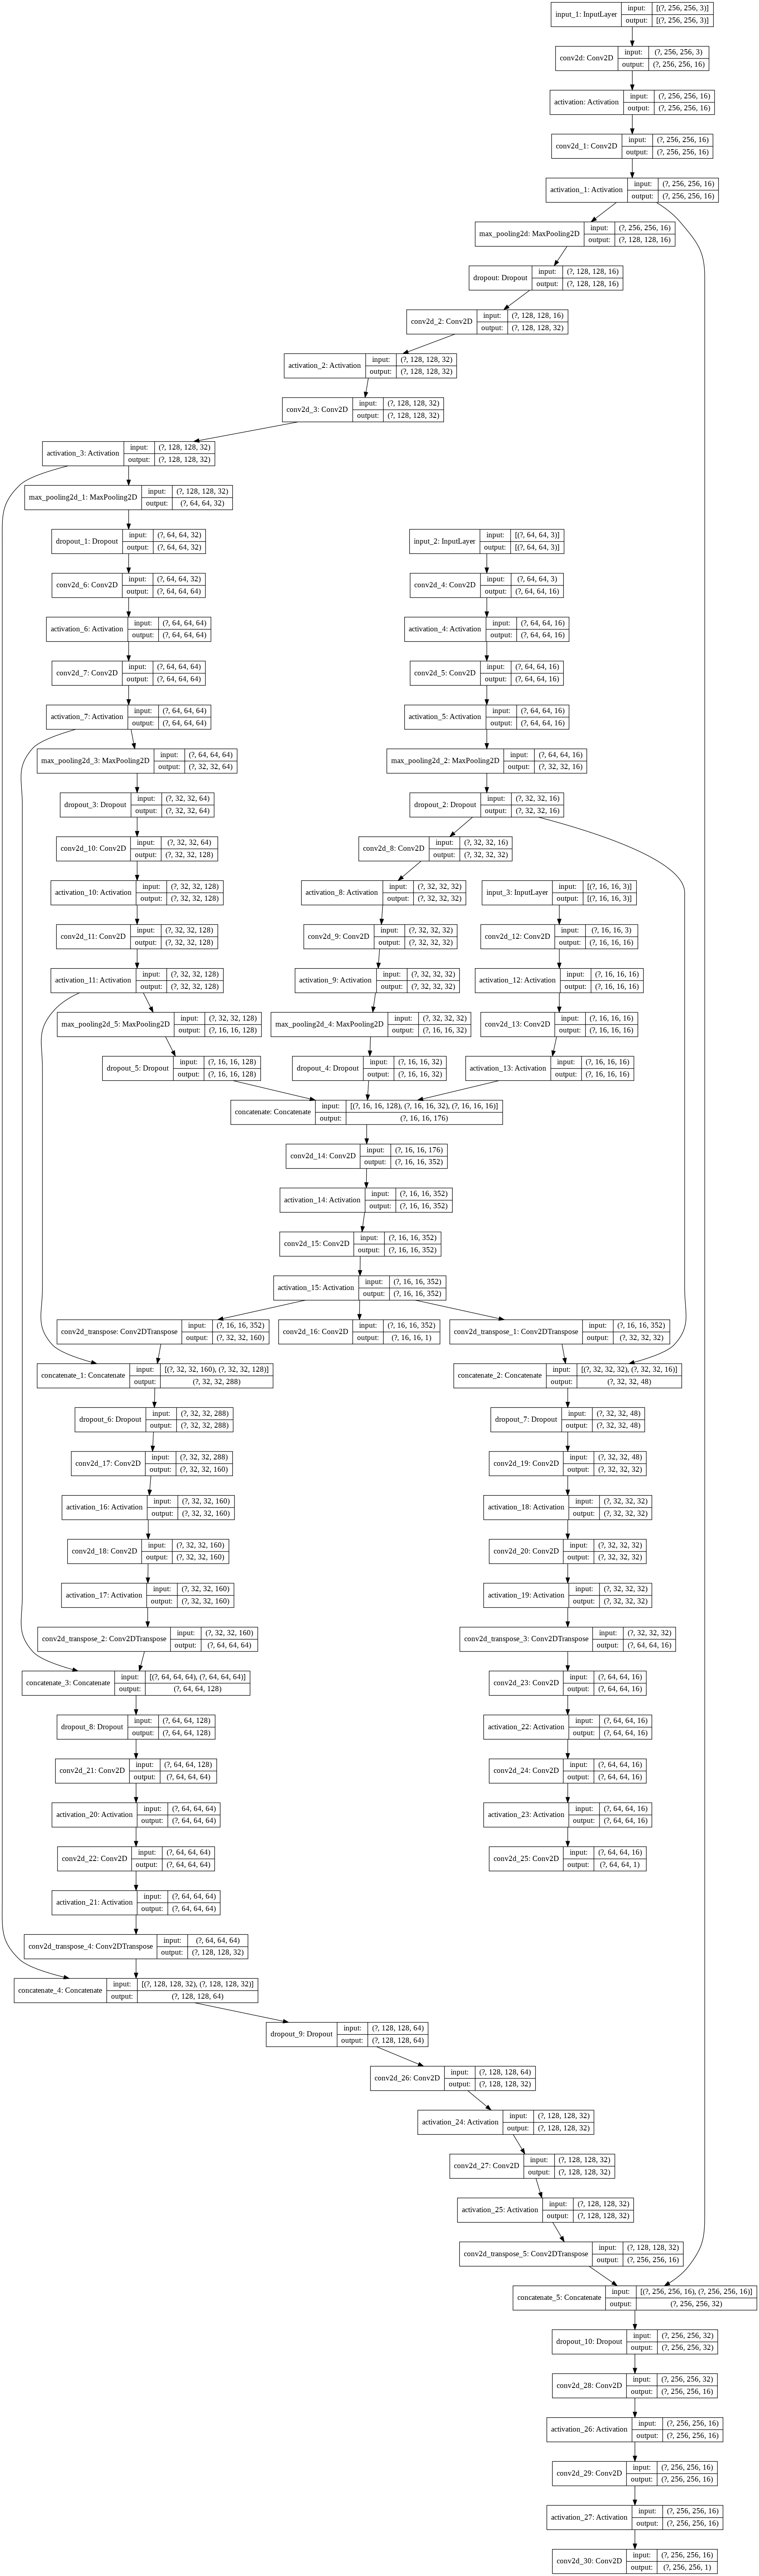

In [ ]:
from keras.utils.vis_utils import plot_model
model = my_unet((256,256,3), (64,64,3), (16,16,3), batchnorm=False)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
batch_size = 32
classNum = 1
input_size1 = (256, 256, 3)
input_size2 = (64, 64, 3)
input_size3 = (16, 16, 3)
epochs = 100
learning_rate = 1e-3
train_num = len(os.listdir(train_image_path))
valid_num = len(os.listdir(valid_image_path))
steps_per_epoch = train_num / batch_size
valid_steps = valid_num / batch_size

In [20]:
def train_Generator():
  return My_DataGenerator(batch_size, level, 'train')
def valid_Generator():
  return My_DataGenerator(batch_size, level, 'valid')
def test_Generator():
  return My_DataGenerator(batch_size, level, 'test')

In [21]:
train_dataset = tf.data.Dataset.from_generator(
    train_Generator,output_types=(
        (tf.float32,tf.float32,tf.float32),
        (tf.int32,tf.int32,tf.int32)
    ),
    output_shapes=(
        (tf.TensorShape([None,256,256,3]),tf.TensorShape([None,64,64,3]),tf.TensorShape([None,16,16,3])), 
        (tf.TensorShape([None,256,256,1]),tf.TensorShape([None,64,64,1]),tf.TensorShape([None,16,16,1]))
    )
)
valid_dataset = tf.data.Dataset.from_generator(
    valid_Generator,output_types=(
        (tf.float32,tf.float32,tf.float32),
        (tf.int32,tf.int32,tf.int32)
    ),
    output_shapes=(
        (tf.TensorShape([None,256,256,3]),tf.TensorShape([None,64,64,3]),tf.TensorShape([None,16,16,3])), 
        (tf.TensorShape([None,256,256,1]),tf.TensorShape([None,64,64,1]),tf.TensorShape([None,16,16,1]))
    )
)
test_dataset = tf.data.Dataset.from_generator(
    test_Generator,output_types=(
        (tf.float32,tf.float32,tf.float32),
        (tf.int32,tf.int32,tf.int32)
    ),
    output_shapes=(
        (tf.TensorShape([None,256,256,3]),tf.TensorShape([None,64,64,3]),tf.TensorShape([None,16,16,3])), 
        (tf.TensorShape([None,256,256,1]),tf.TensorShape([None,64,64,1]),tf.TensorShape([None,16,16,1]))
    )
)


In [22]:
train_dataset = train_dataset.repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
for i,j in train_dataset.take(1):
  break
print(i[0].shape, i[1].shape, i[2].shape, j[0].shape, j[1].shape, j[2].shape)

(32, 256, 256, 3) (32, 64, 64, 3) (32, 16, 16, 3) (32, 256, 256, 1) (32, 64, 64, 1) (32, 16, 16, 1)


In [ ]:
model = my_unet(input_shape1=input_size1, input_shape2=input_size2, input_shape3=input_size3)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=100, verbose=2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20, min_lr=0.00005, verbose=2)
model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/4995/ProjectMM/unet_membrane.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
for i in range(5):
  history = model.fit(train_dataset,
          steps_per_epoch = steps_per_epoch,
          epochs = 8,
          validation_data = valid_dataset,
          validation_steps = valid_steps,
          callbacks=callbacks)


Epoch 1/8
832/831 [==============================] - ETA: 0s - loss: 74.1349 - conv2d_92_loss: 27.3823 - conv2d_87_loss: 21.8443 - conv2d_78_loss: 24.9083 - conv2d_92_accuracy: 0.9899 - conv2d_87_accuracy: 0.9893 - conv2d_78_accuracy: 0.9865
Epoch 00001: val_loss did not improve from 1064.14368
832/831 [==============================] - 283s 340ms/step - loss: 74.1349 - conv2d_92_loss: 27.3823 - conv2d_87_loss: 21.8443 - conv2d_78_loss: 24.9083 - conv2d_92_accuracy: 0.9899 - conv2d_87_accuracy: 0.9893 - conv2d_78_accuracy: 0.9865 - val_loss: 2304.8120 - val_conv2d_92_loss: 1095.4711 - val_conv2d_87_loss: 775.4666 - val_conv2d_78_loss: 433.8751 - val_conv2d_92_accuracy: 0.9759 - val_conv2d_87_accuracy: 0.9756 - val_conv2d_78_accuracy: 0.9712
Epoch 2/8
832/831 [==============================] - ETA: 0s - loss: 72.2410 - conv2d_92_loss: 25.6392 - conv2d_87_loss: 21.0426 - conv2d_78_loss: 25.5592 - conv2d_92_accuracy: 0.9904 - conv2d_87_accuracy: 0.9898 - conv2d_78_accuracy: 0.9868
Epoch 0

In [ ]:
model.save('/content/drive/My Drive/4995/ProjectMM/model4.h5')

In [6]:
my_loss1 = focal_loss(2,0.93,1)
my_loss2 = focal_loss(2,0.93,12)
my_loss3 = focal_loss(2,0.93,144)
model = keras.models.load_model('/content/drive/My Drive/4995/ProjectMM/model4.h5', custom_objects={'focal_loss_fixed': [my_loss1, my_loss2, my_loss3]})

In [7]:
def select_area(pred):
  height = pred.shape[0]
  width = pred.shape[1]
  iter = 0
  while iter<2:
    iter += 1
    new_pred = pred.copy()
    np.mean(pred)
    for i in range(height):
      for j in range(width):
        if pred[i,j] <1:
          count = 0
          mask = 0
          setk = [(i-1,j-1),(i,j-1),(i+1,j-1),(i-1,j),(i+1,j),(i-1,j+1),(i,j+1),(i+1,j+1),(i-2,j-2),(i,j-2),(i+2,j-2),(i-2,j-2)]
          for k in setk:
            try:
              mask += pred[k[0],k[1]]
              count += 1
            except:
              pass
          if mask > 0.5*count:
            new_pred[i,j] = 1
    if np.mean((pred - new_pred)**2)<np.mean(pred)*0.4:
      break
    pred = new_pred
  return new_pred


In [23]:
n = 4
k = 0
plt.figure(figsize=(20, 5*batch_size))
for image, mask in test_dataset:
  pred = model.predict(image)
  image = image[k]
  mask = mask[k]
  pred = pred[k]
  pred[pred>0.5] = 1
  pred[pred<0.5] = 0
  pred.astype(int)
  count = 0
  for i in range(batch_size):
    ax = plt.subplot(batch_size, n, i*n + 1)
    plt.imshow(image[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(batch_size, n, i*n + 2)
    plt.imshow(mask[i,:,:,0])
    if np.mean(mask[i,:,:,0])>0:
      count += 1
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(batch_size, n, i*n + 3)
    plt.imshow(pred[i,:,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(batch_size, n, i*n + 4)
    plt.imshow(select_area(pred[i,:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  break

Output hidden; open in https://colab.research.google.com to view.